In [3]:
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings

%load_ext watermark

%watermark -v -p os,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.8.0

os        : unknown
pandas    : 1.5.2
matplotlib: 3.6.2



Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.8.0

os        : unknown
pandas    : 1.5.2
matplotlib: 3.6.2

In [4]:
warnings.filterwarnings("ignore")
#warnings.filterwarnings("defalt")

In [5]:
# Global Variables

data_file_path = 'Data'
image_file_path = 'Images'

migration_df = pd.read_csv(os.path.join(data_file_path, "Master_Migration_2000_2019.csv"))
migration_full_range_df = pd.read_csv(os.path.join(data_file_path, "Migration_2000_2019.csv"))


In [6]:
def generate_bar_chart (ax, start_year, stop_year, country_count, field_name, ascending ) :

    the_df = migration_full_range_df
    the_df.sort_values ( by = field_name, ascending=False, inplace=True )

    top_countries = the_df.head(country_count)
    bottom_countries = the_df.tail(country_count)

    combined_data = pd.concat([top_countries, bottom_countries])

    bars = ax.barh(combined_data['country'], combined_data['migration_count'],
                      color=[('red' if val < 0 else 'blue') for val in combined_data['migration_count']])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust the fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust the fontsize
    ax.set_xlabel('Average Net Migration', fontsize=12)
    ax.set_title(f'Average Net Migration ( {start_year} - {stop_year} )', fontsize=15)
    ax.legend(handles=[bars[0], bars[-1]], labels=['Migration Inflow', 'Migration Outflow'])
    ax.invert_yaxis()  # Invert y-axis to have the highest value at the top



In [7]:
def generate_stack_chart (ax, start_year, stop_year, country_count, field_name, ascending ) :

    filtered_migration_df = migration_df[(migration_df['year'] >= start_year) & (migration_df['year'] <= stop_year)]

    # Group by country and calculate total migration over the years
    grouped = filtered_migration_df.groupby('country')[field_name].sum().sort_values(ascending=ascending)

    # Select the top countries
    top_countries = grouped.head(country_count)
    ordered_countries = top_countries.sort_values(ascending=ascending).index

    print(top_countries)
    print(ordered_countries)

    filtered_migration_df['migration_count'] = filtered_migration_df[field_name].abs()

    pivot_df = filtered_migration_df[filtered_migration_df['country'].isin(top_countries.index)].pivot(index='year', columns='country', values=field_name)

    pivot_df.index = pivot_df.index.astype(str)
    scaling_factor = 1e6
    pivot_df /= scaling_factor

    stack_data = [pivot_df[country] for country in ordered_countries]

    print(pivot_df)

    ax.stackplot(pivot_df.index, stack_data, labels=ordered_countries)

    # Create the stack plot with highest values at the bottom
    #ax.figure(figsize=(10, 6))
    #ax.stackplot(pivot_df.index, pivot_df.values.T, labels=pivot_df.columns[::-1])  # Transpose the values

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust the fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)  # Adjust the fontsize
    ax.set_xlabel('Year', fontsize=15)


In [8]:
def generate_line_chart (ax, start_year, stop_year, country_count, field_name, ascending) :

    # Calculate the total migration for each country at the start year

    filtered_migration_df = migration_df[(migration_df['year'] >= start_year) & (migration_df['year'] <= stop_year)]

    # Group by country and calculate total migration over the years
    grouped = filtered_migration_df.groupby('country')[field_name].sum().sort_values(ascending=ascending)

    # Select the top 20 countries
    top_countries = grouped.head(country_count)

    filtered_top_countries_df = filtered_migration_df[filtered_migration_df['country'].isin(top_countries.index)]
    #filtered_top_countries_df = filtered_top_countries_df[filtered_top_countries_df['country'] != 'Venezuela, RB']
    #filtered_top_countries_df = filtered_top_countries_df[filtered_top_countries_df['country'] != 'Iraq']

    start_year_totals = filtered_top_countries_df[filtered_top_countries_df['year'] == start_year].set_index('country')[field_name]

    # Normalize data to 100 at the start year
    normalized_df = filtered_top_countries_df.pivot(index='year', columns='country', values=field_name) / start_year_totals * 100
    normalized_df.index = normalized_df.index.astype(str)

    # Create the line chart

    normalized_df.plot(ax=plt.gca())

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust the fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust the fontsize
    ax.set_xlabel('Year', fontsize=12)

    ax.set_ylabel('Normalized Net Migration')
    ax.set_title(f'Normalized Net Migration Over {stop_year - start_year} Years')



In [9]:
def generate_3_Panel_chart ( start_year, stop_year, country_count ) :

    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 2])

    # Create axes for each cell in the grid
    ax1 = fig.add_subplot(gs[:, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])

# Create charts and images

    generate_bar_chart (ax1, start_year, stop_year, country_count, 'migration_count', False)

    ax3.set_ylabel('Migration Inflows in (Millions)', fontsize=15)
    ax3.set_title(f'Top {country_count} Countries with Highest Migration Inflows')
    generate_stack_chart (ax3, start_year, stop_year, country_count, 'migration_count', False)
    ax3.legend(loc='upper right')

    ax4.set_ylabel('Migration Outflow in (Millions)', fontsize=15)
    ax4.set_title(f'Top {country_count} Countries with Highest Migration Outflows')
    generate_stack_chart (ax4, start_year, stop_year, country_count, 'migration_count', True)
    ax4.legend(loc='upper left')

    # Adjust layout
    plt.tight_layout()


    plt.savefig( os.path.join ( image_file_path, f"3_Panel_chart_{start_year}-{stop_year}.jpg" ) )  # For JPG format
    plt.savefig( os.path.join ( image_file_path, f"3_Panel_chart_{start_year}-{stop_year}.png" ))  # For PNG format


country
United States           24393517.0
Russian Federation       6306354.0
Spain                    5733423.0
United Kingdom           4971617.0
Canada                   4968943.0
Germany                  4766691.0
United Arab Emirates     4489449.0
Saudi Arabia             4116609.0
Italy                    4025250.0
Australia                3799853.0
Malaysia                 3141537.0
Iran, Islamic Rep.       3134506.0
Japan                    2861964.0
Jordan                   2457426.0
Qatar                    1863053.0
Name: migration_count, dtype: float64
Index(['United States', 'Russian Federation', 'Spain', 'United Kingdom',
       'Canada', 'Germany', 'United Arab Emirates', 'Saudi Arabia', 'Italy',
       'Australia', 'Malaysia', 'Iran, Islamic Rep.', 'Japan', 'Jordan',
       'Qatar'],
      dtype='object', name='country')
country  Australia    Canada   Germany  Iran, Islamic Rep.     Italy  \
year                                                                   
2000   

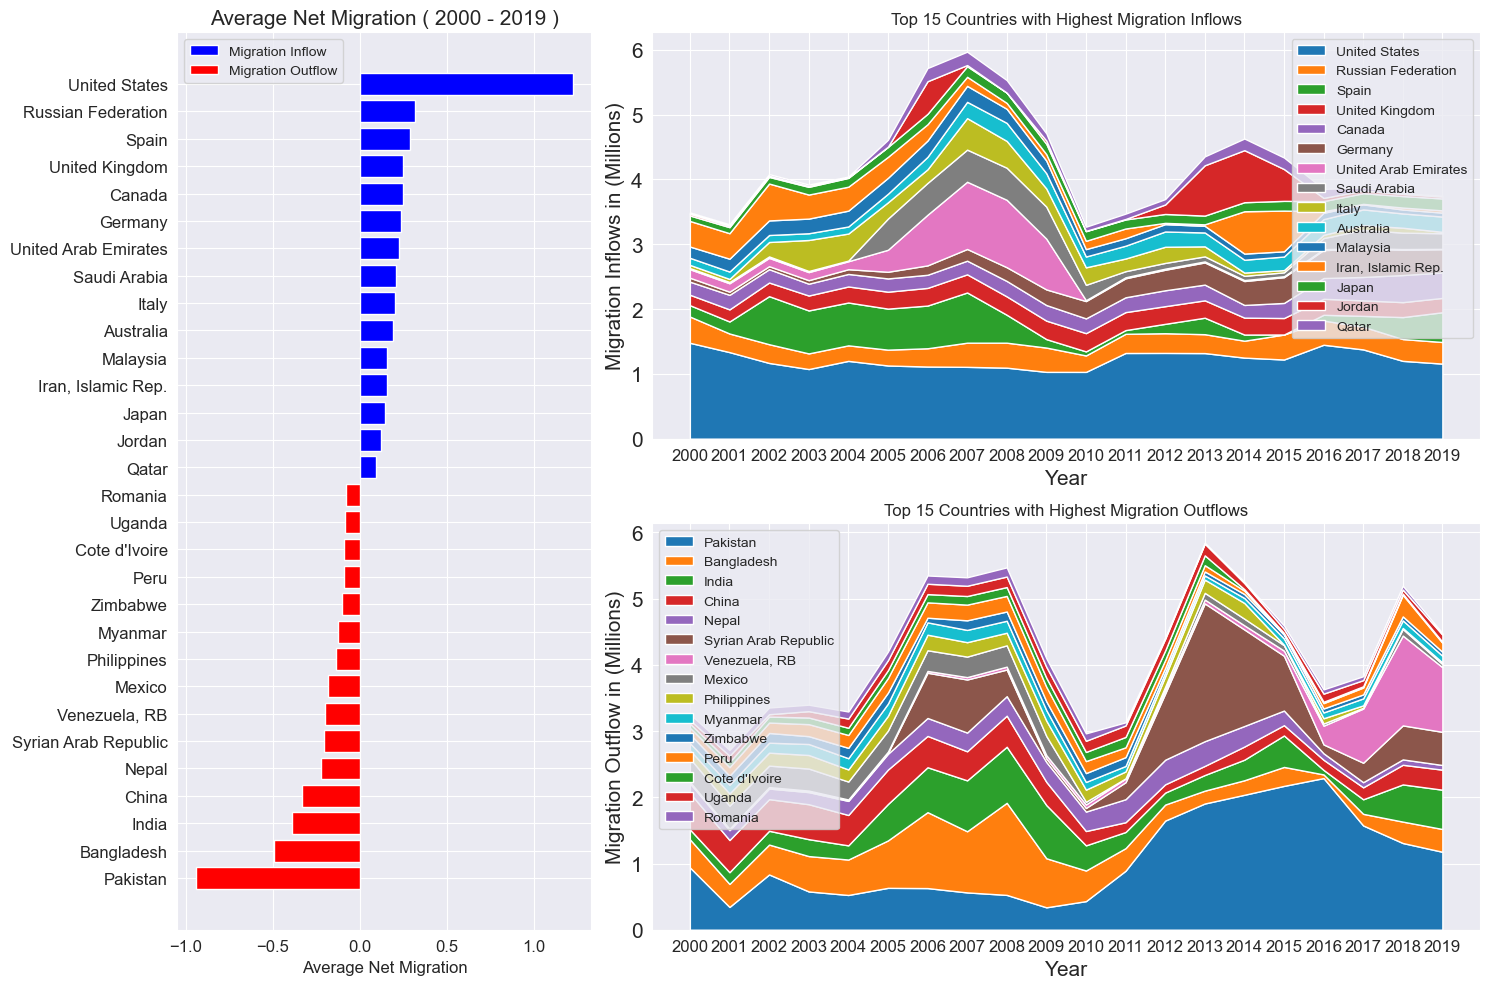

In [10]:
country_count = 15

start_year = 2000
stop_year = 2019

generate_3_Panel_chart ( start_year, stop_year, country_count )


In [2]:
country_count = 15

start_year = 2000
stop_year = 2019

generate_3_Panel_chart ( start_year, stop_year, country_count )

start_year = 2000
stop_year = 2004

generate_3_Panel_chart ( start_year, stop_year, country_count )

start_year = 2005
stop_year = 2009

generate_3_Panel_chart ( start_year, stop_year, country_count )

start_year = 2010
stop_year = 2014

generate_3_Panel_chart ( start_year, stop_year, country_count )

start_year = 2015
stop_year = 2019

generate_3_Panel_chart ( start_year, stop_year, country_count )


NameError: name 'generate_3_Panel_chart' is not defined